### 머신러닝을 이용한 투자 전략
* 머신러닝을 이용한 투자 전략을 만드는 데 필요한 지도를 제공하는 예제
* 직관적이고 해석이 용이한 트리 기반의 앙상블 모델을 사용하는 예시


* 각 변수(종가, 거래량 등)를 트레이더 한 사람의 투자 기준(의견)으로 간주,

 예를 들어 금 가격을 변수로 설정하고 예측하고자 하는 종목의 트렌드(상승/하락)을 레이블 변수로 설정한다면, 금 가격에 기반한 투자 의사결정을 할 수 있는 모델을 만드는 셈
* 다양한 변수를 사용해 고차원 공간에서 변수 간의 관계를 찾는다면, 여러 트레이더의 의견을 종합해 트렌드를 예측하는 것이 되고, 이것이 머신러닝의 역할이다.

### 데이터
* 데이터 전처리
 * 파생 변수(기술적 지표) 생성
 * 인덱스 설정('Dates' 열)
 * 타겟 변수 생성
 * 훈련 및 테스트 셋 생성
* 평가 지표 함수 정의


In [43]:
import warnings
import glob
import os
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import plot_tree
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import svm
import seaborn as sns; sns.set()

In [44]:
print(os.getcwd())

/content


ETF 데이터를 머신러닝 모델의 설명 변수(input data)로 사용하는 이유

1. ETF는 다양한 자산을 포함하는 펀드로, 단일 주식이나 자산에 비해 시장의 광범위한 동향을 더 잘 포착하여 개별 주식의 특정 리스크를 줄이고, 전체 시장 또는 특정 섹터의 평균적인 성과를 추적하는 데 유용

2. 거시경제 지표 대신 ETF 데이터를 사용하는 이유는 실시간성과 접근성에 있음
거시경제 지표는 발표가 지연되거나 때때로 수정될 수 있는 반면, ETF는 거래소에서 실시간으로 거래되어 시장의 현재 상태를 더 정확히 반영하기 때문

In [45]:
#해당 셀 실행 전 데이터를 업로드
df = pd.read_csv('./ETFs_main.csv')

In [46]:
# 기술적 지표 만들기
# 지표 계산에 이동평균 등을 활용하여 데이터에 내재된 잡음을 줄이게 됨
def moving_average(df, n):
    MA = pd.Series(df['CLOSE_SPY'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    df = df.join(MA)
    return df

def volume_moving_average(df, n):
    VMA = pd.Series(df['VOLUME'].rolling(n, min_periods=n).mean(), name='VMA_' + str(n))
    df = df.join(VMA)
    return df

def relative_strength_index(df, n):
    delta = df['CLOSE_SPY'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=n).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=n).mean()
    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))
    RSI.name = 'RSI_' + str(n)
    df = df.join(RSI)
    return df

In [47]:
# 기술 지표 적용
df = moving_average(df, 45)
df = volume_moving_average(df, 45)
df = relative_strength_index(df, 14)

# 'Dates' 열을 인덱스로 설정
df = df.set_index('Dates')
df = df.dropna() # 이동평균 지수를 만들면 사용한 일수만큼 결측값이 생기게 된다. 해당 결측값을 처리
print(len(df))

2727


In [48]:
# 타겟 변수 생성 (pct_change)
df['pct_change'] = df['CLOSE_SPY'].pct_change()

# 모델링을 위한 이진 분류 값 생성
df['target'] = np.where(df['pct_change'] > 0, 1, 0)
df = df.dropna(subset=['target'])  # 결측값 제거

# 정수형 변환
df['target'] = df['target'].astype(np.int64)

print(df['target'].value_counts()) # 불균형 데이터가 아닌 것을 확인

target
1    1471
0    1256
Name: count, dtype: int64


In [49]:
# 다음날 예측을 위해 타겟 변수를 shift
df['target'] = df['target'].shift(-1)
df = df.dropna() # shift로 생긴 결측값 제거
print(len(df))

2725


In [50]:
# 설명 변수와 타겟 변수 분리
y_var = df['target']
x_var = df.drop(['target', 'OPEN', 'HIGH', 'LOW', 'VOLUME', 'CLOSE_SPY', 'pct_change'], axis=1)

In [51]:
# 상승과 하락 비율 확인
up = df[df['target'] == 1].target.count()
total = df.target.count()
print('up/down ratio: {0:.2f}'.format(up / total))

up/down ratio: 0.54


만약 모델이 오른다고만 응답해도 54%의 정확도를 지니게 됨

머신러닝 기반의 주가 트렌드 분류 모델이 54~56% 정도의 정확도를 가진다면 매우 훌륭한 모델이지만

정확도만이 아니라 종합적인 지표(AUC-ROC, 투자 성과 관련 지표)를 고려해야 함

### 모델 학습

In [52]:
# 훈련셋과 테스트셋 분할
# 기간이 섞이면 안되므로 shuffle 인자에 False를 지정
X_train, X_test, y_train, y_test = train_test_split(x_var, y_var, test_size=0.3, shuffle=False, random_state=3)

# 훈련셋과 테스트셋의 양성 샘플 비율이 유사한지 확인
train_count = y_train.count()
test_count = y_test.count()

print('train set label ratio')
print(y_train.value_counts() / train_count)
print('test set label ratio')
print(y_test.value_counts() / test_count)

train set label ratio
target
1.0    0.543786
0.0    0.456214
Name: count, dtype: float64
test set label ratio
target
1.0    0.530562
0.0    0.469438
Name: count, dtype: float64


In [53]:
x_var.head( )

,CLOSE_GLD,CLOSE_FXY,CLOSE_T10Y2Y,CLOSE_TED,CLOSE_USO,CLOSE_UUP,CLOSE_VIX,CLOSE_VWO,MA_45,VMA_45,RSI_14
Dates,,,,,,,,,,,
2007-04-30,67.09,83.7166,2.4361,0.57,51.24,24.49,14.22,40.935,143.601556,1.116466e+08,70.956720
2007-05-02,66.66,83.3800,2.4366,0.59,49.59,24.66,13.08,42.020,143.680667,1.121613e+08,79.237288
2007-05-03,67.49,83.1100,2.4346,0.60,49.28,24.69,13.09,42.435,143.780222,1.123421e+08,79.604579
2007-05-04,68.19,83.2300,2.4006,0.60,48.30,24.60,12.91,42.595,143.905111,1.128853e+08,79.411765
2007-05-08,67.88,83.3700,2.3913,0.60,48.64,24.73,13.21,42.360,144.029111,1.131357e+08,74.368231


In [54]:
#혼동 행렬 및 성능 평가 함수
def get_confusion_matrix(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_score = roc_auc_score(y_test, pred)
    print('confusion matrix')
    print(confusion)
    print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f}, F1: {3:.4f}, ROC AUC score: {4:.4f}'.format(
        accuracy, precision, recall, f1, roc_score))


### 머신러닝 모델(XGBoost)을 활용한 결과 예측

새로운 데이터(test 셋)에 대한 예측 수행

훈련 데이터에서 84.7%의 정확도를 보여주었으나, 모델이 과적합되었을 가능성을 고려해야함

In [55]:
#모델 학습 및 평가
# XGBoost 모델 학습 및 예측
xgb_dis = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_dis.fit(X_train, y_train)
xgb_pred = xgb_dis.predict(X_test)

# 훈련 정확도 확인
print(xgb_dis.score(X_train, y_train))

# 성능 평가
get_confusion_matrix(y_test, xgb_pred)


0.8479286837965391
confusion matrix
[[333  51]
 [358  76]]
accuracy: 0.5000, precision: 0.5984, recall: 0.1751, F1: 0.2709, ROC AUC score: 0.5212


<Figure size 60000x30000 with 0 Axes>

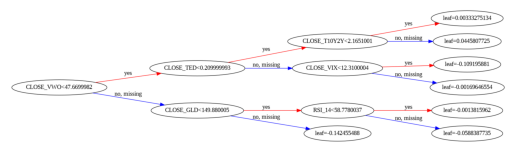

In [56]:
# 첫 번째 트리 시각화
plt.figure(figsize=(20, 10), dpi=3000)
plot_tree(xgb_dis, num_trees=0, rankdir="LR")  # num_trees=0은 첫 번째 트리
plt.show()

<Figure size 20000x10000 with 0 Axes>

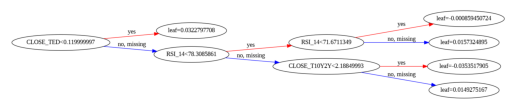

In [57]:
# 마지막 트리 시각화
plt.figure(figsize=(200, 100))
plot_tree(xgb_dis, num_trees=399, rankdir="LR")
plt.show()

#### 트리 기반 머신러닝 모델의 매개변수
* **학습률** : 0에서 1 사이의 값을 지정해 부스팅 스텝을 반복적으로 수행할 때 업데이트되는 학습률값을 뜻한다. 이전 트리의 오차를 얼마나 강하게 보정할 것인지를 제어한다. 일반적인 경우에 0.01~0.2의 값을 사용한다.
 * learning_rate (LightGBM)
 * eta (Xgboost)

* **트리 수** : 반복 수행하려는 트리의 개수를 지정한다. 트리를 많이 만들수록 성능이 좋아질 수는 있지만 과적합의 위험도 커진다. LightGBM에서 디폴트로 설정된 값이 100이므로 큰 값으로 재설정하는 것이 좋다.
 * num_iterations (LightGBM)
 * n_estimators (Xgboost, Random Forest)
* **트리 깊이** : 트리의 최대 깊이를 설정한다. 디폴트는 Xgboost에서 6이고, LightGBM에서는 -1로 깊이에제한이 없다.이 값이 너무 크면 과적합될 확률이 매우 크므로, 보통 3~10의 값을 사용한다. 변수가 많은 경우, 높게 설정하도록 한다.
 * max_depth (LightGBM,Xgboost, Random Forest)

* **조기 종료** : 검증 정확도가 더이상 올라가지 않을 때 지정된 학습 횟수 이전에 종료하는 방법이다. 검증셋이 없다면 지정하지 않아도 된다.
 * early_stopping_rounds (LightGBM)
 * early_stopping_round (XGBoost)

* **서브 샘플링** : 일부 데이터만을 사용하는 배깅의 비율을 뜻하며, 과적합을 제어하기 위한 수단이다. 0.5를 지정하면 전체 데이터의 절반을 트리 생성에 사용한다. 일반적으로 0.5~1의 값을 사용한다.
 * bagging_fraction (LightGBM)
 * subsample (XGBoost)

* **변수 샘플링** : 트리 생성에 필요한 변수(컬럼)를 샘플링하는 데 사용된다. 변수가 너무 많을 경우 과적합을 줄이는 방법으로 활용된다. 기본적으로 1로 설정하면 변수 샘플링을 하지 않게 되며, 설정한다면 보통 0.7~0.9 값을 많이 사용한다.

 * feature_fraction (LightGBM)
 * colsample_bytree (XGBoost)

* **가중치 조절** : 과적합을 조절하는 데 사용된다. 높은 값은 특정 샘플에 높은 의존도를 가지는 모델이되는 것을 방지한다. 높은 값을 설정할수록 모델이 보수적이 된다. 그러나 너무 높은 값을 설정하면 과소적합될 수 있으므로 교차 검증을통해 최적의 값을 찾아야 한다.

 * min_sum_hessian_in_leaf (LightGBM)
 * min_child_weight

* **최대 리프 수** : 개별 트리가 가질 수 있는 최대 리프 수를 뜻한다. LightGBM 모델의 복잡도를 제어하는 주요 파라미터다. 트리가 매우 깊을 경우 num_leaves를 조정하면 효과를 볼 수 있다.
 * num_leaves(LightGBM)

* **감마** : 분할을 수행하는 데 필요한 최소 손실 감소를 지정한다. 값이 클수록 과적합 감소 효과가 있다.
 * gamma(Xgboost)

기타 매개변수는 공식 documentation을 참고

### 랜덤 포레스트 모델 사용

임의의 파라미터를 지정하는 것이 아니라 여러 파라미터 조합에 대해 교차검증(CV)를 수행하는 GridSearchCV()를 사용

TimeSeriesSplit의 gap 매개변수를 활용하면 퍼징을 적용 가능

현재는 daily한 종가 데이터를 사용하므로 퍼징 없이도 정보 누수가 충분히 적다고 가정

In [58]:
# 기존 40분 이상 소요.. 현재 코드는 5x4x5x20 = 2000 개 조합 확인
# 또한 CV를 5개 데이터에 대해 수행하므로 2000x5 = 10000번의 학습 및 검정
# 수정한 코드는 3x3x4x5=180개
# cv도 3으로 -> 540
# 2분 정도 소요

# 랜덤 포레스트 매개변수 설정
n_estimators = range(10, 100, 20)
params = {
    'bootstrap': [True],
    'n_estimators': n_estimators,
    'max_depth': [4, 8, 12],
    'min_samples_leaf': [2, 3, 4],
    'min_samples_split': [2, 4, 6, 8],
    'max_features': [4]
}

# 교차 검증 설정
my_cv = TimeSeriesSplit(n_splits=3).split(X_train) #forward walking cross validation

# GridSearchCV를 사용한 모델 학습
clf = GridSearchCV(RandomForestClassifier(), params, cv=my_cv, n_jobs=-1)
clf.fit(X_train, y_train)

# 최적의 매개변수와 정확도 출력
print('best parameter:\n', clf.best_params_)
print('best prediction: {0:.4f}'.format(clf.best_score_))

best parameter:
 {'bootstrap': True, 'max_depth': 8, 'max_features': 4, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 10}
best prediction: 0.5469


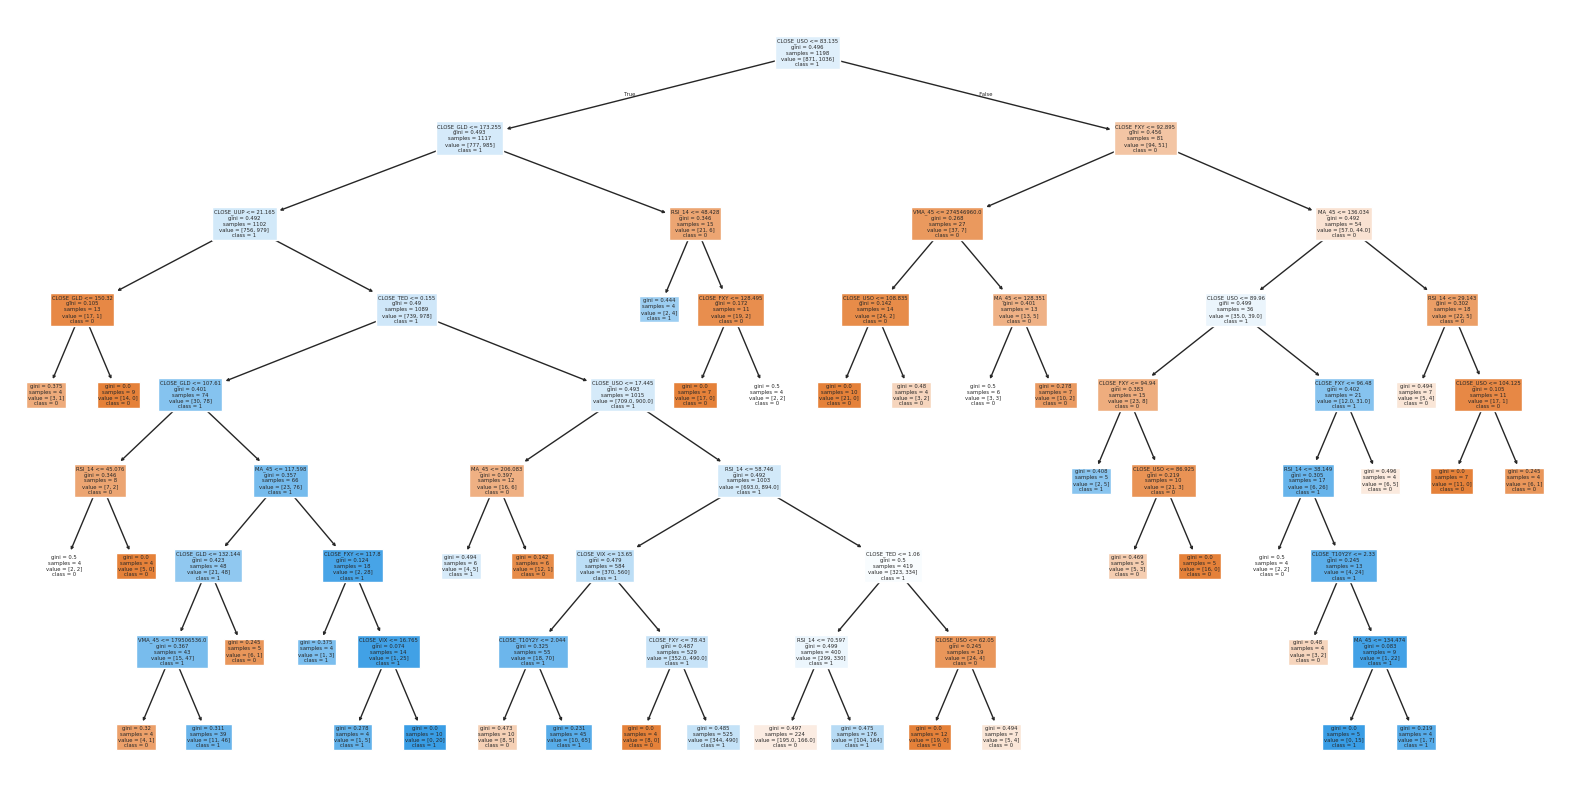

In [61]:
from sklearn.tree import plot_tree
# 첫 번째 트리 시각화
plt.figure(figsize=(20, 10))
plot_tree(clf.best_estimator_.estimators_[0], filled=True, feature_names=X_train.columns, class_names=["0", "1"])
plt.show()

In [62]:
# 테스트셋에서의 성능 확인
pred_con = clf.predict(X_test)
accuracy_con = accuracy_score(y_test, pred_con)
print('accuracy: {0:.4f}'.format(accuracy_con))
get_confusion_matrix(y_test, pred_con)

accuracy: 0.4817
confusion matrix
[[375   9]
 [415  19]]
accuracy: 0.4817, precision: 0.6786, recall: 0.0438, F1: 0.0823, ROC AUC score: 0.5102


#### target 변수 수정해서 진행
* 0.01% 상승과 10% 상승을 비교해보았을 때 0.01%의 경우 모델이 등락을 판단하기가 더 어려울 수 있음
* 따라서 큰 폭으로 오르는 트렌드만 포착하도록 모델을 훈련시키도록 수정

In [63]:
# 타겟 변수 통계 확인
df['pct_change'].describe()

,pct_change
count,2725.000000
mean,0.000271
std,0.013029
min,-0.098448
25%,-0.004321
50%,0.000545
75%,0.005791
max,0.128249


타겟 변수의 통계를 확인해 보았을 때, 평균적으로 일 0.02% 상승했고, 표준편차가 1.3%임을 확인할 수 있다.

In [64]:
# 타겟 변수 정의 변경 (평균보다 높은 0.05% 이상의 수익률을 얻는 경우를 포착하고 싶음)
df['target'] = np.where(df['pct_change'] > 0.0005, 1, -1)
df['target'].value_counts()

,count
target,
1,1375
-1,1350


In [65]:
# 다음날 예측을 위해 타겟 변수를 shift
df['target'] = df['target'].shift(-1)
df = df.dropna()

# 타겟 변수를 1과 0으로 변환
df = df.copy()
df['target'] = df['target'].replace(-1, 0)
print(df['target'].value_counts())  # 변환된 결과 확인

# 설명 변수와 타겟 변수 분리
y_var = df['target']
x_var = df.drop(['target', 'OPEN', 'HIGH', 'LOW', 'VOLUME', 'CLOSE_SPY', 'pct_change'], axis=1)

# 훈련셋과 테스트셋 분할
X_train, X_test, y_train, y_test = train_test_split(x_var, y_var, test_size=0.3, shuffle=False, random_state=3)

target
1.0    1375
0.0    1349
Name: count, dtype: int64


In [66]:
# 랜덤 포레스트 매개변수 설정
n_estimators = range(10, 100, 20)
params = {
    'bootstrap': [True],
    'n_estimators': n_estimators,
    'max_depth': [4, 8, 12],
    'min_samples_leaf': [2, 3, 4],
    'min_samples_split': [2, 4, 6, 8],
    'max_features': [4]
}

# 교차 검증 설정
my_cv = TimeSeriesSplit(n_splits=3).split(X_train)

# GridSearchCV를 사용한 모델 학습
clf = GridSearchCV(RandomForestClassifier(), params, cv=my_cv, n_jobs=-1)
clf.fit(X_train, y_train)

GridSearchCV(cv=<generator object TimeSeriesSplit._split at 0x79955847fb60>,
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [4, 8, 12],
                         'max_features': [4], 'min_samples_leaf': [2, 3, 4],
                         'min_samples_split': [2, 4, 6, 8],
                         'n_estimators': range(10, 100, 20)})

In [67]:
# 최적의 매개변수와 정확도 출력
print('best parameter:\n', clf.best_params_)
print('best prediction: {0:.4f}'.format(clf.best_score_))

best parameter:
 {'bootstrap': True, 'max_depth': 8, 'max_features': 4, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 10}
best prediction: 0.5182


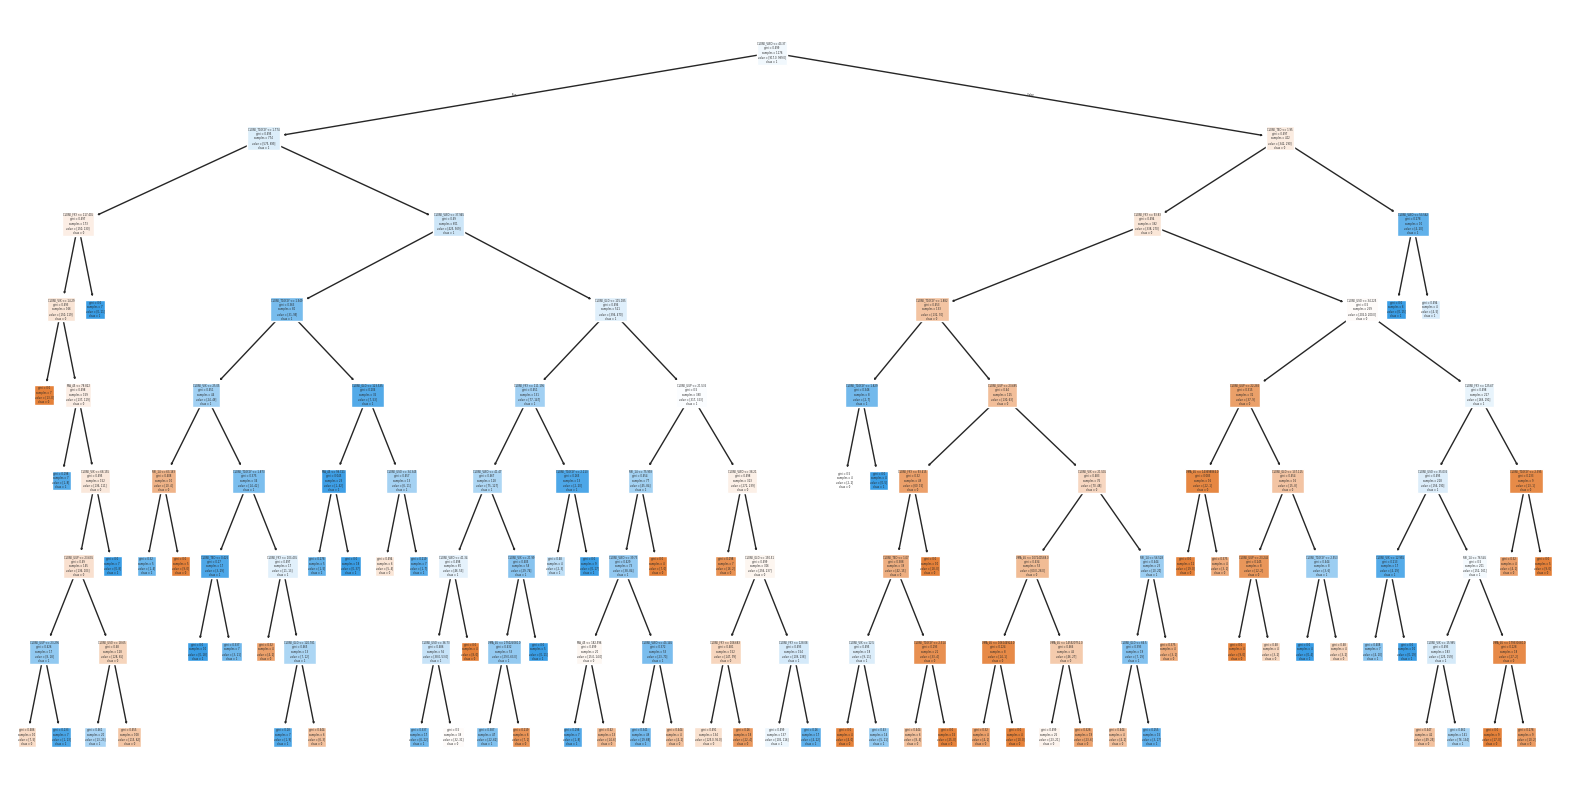

In [68]:
# 첫 번째 트리 시각화
plt.figure(figsize=(20, 10))
plot_tree(clf.best_estimator_.estimators_[0], filled=True, feature_names=X_train.columns, class_names=["0", "1"])
plt.show()

In [69]:
# 테스트셋에서 모델의 일반화 성능 확인
pred_con = clf.predict(X_test)
accuracy_con = accuracy_score(y_test, pred_con)
print('accuracy: {0:.4f}'.format(accuracy_con))
get_confusion_matrix(y_test, pred_con)

accuracy: 0.5232
confusion matrix
[[295 120]
 [270 133]]
accuracy: 0.5232, precision: 0.5257, recall: 0.3300, F1: 0.4055, ROC AUC score: 0.5204


### 확장 가능한 방법
* 다중 분류 문제로 바꿔본다.
 * 상승, 하락 뿐 아니라 보합, 3% 이상 상승, 3% 이상 하락 등의 다양한 시나리오를 class로 설정
* 사용하는 머신러닝 알고리즘을 바꿔본다.
* 변수를 바꿔본다.
* 예측하려는 종목/자산을 바꿔본다.
* 노이즈 제거 방법(웨이블릿 변환, 주성분 분석, 오토인코더, 로패스필터 등)을 적용해본다.